In [66]:
# Loading NN-Benchmark model

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 800)  # 800 = 400*2 (400 points, 2d)

    def forward(self, x):  # x are the states: [d_obs_x, d_obs_y, d_goal_x, d_goal_y]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model_path = '/home/yigit/Documents/projects/irl_sfm/python_ws/nn_baseline_for_cnmp/model/nn_models/model_traj_est_state_dict_new_combined.pt'
benchmark_model = Net()
benchmark_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [67]:
def create_test_configuration_():
    sy, gy, ox, oy = 0.0, 13.0, 1.0, 6.0
    config = torch.zeros((20, 6))
    config[0,:] = torch.Tensor([0, sy, 0, gy, ox, oy])
    config[1,:] = torch.Tensor([0, sy, 2, gy, ox, oy])
    config[2,:] = torch.Tensor([0, sy, -2, gy, ox, oy])
    config[18,:] = torch.Tensor([2, sy, 0, gy, ox, oy])
    config[4,:] = torch.Tensor([2, sy, 2, gy, ox, oy])
    config[5,:] = torch.Tensor([2, sy, -2, gy, ox, oy])
    config[6,:] = torch.Tensor([-2, sy, 0, gy, ox, oy])
    config[7,:] = torch.Tensor([-2, sy, 2, gy, ox, oy])
    config[8,:] = torch.Tensor([-2, sy, -2, gy, ox, oy])
    
    config[19,:] = torch.Tensor([0, sy, 0, gy, 0, 10])
    config[14,:] = torch.Tensor([2, sy, 2, gy, 2, 3])
    config[13,:] = torch.Tensor([-2, sy, -2, gy, -2, 6.5])
    config[12,:] = torch.Tensor([-2, sy, 0, gy, -1, 8.5])
    config[11,:] = torch.Tensor([0, sy, 2, gy, 1, 4.5])
    config[10,:] = torch.Tensor([2, sy, -2, gy, 0, 6.5])
    config[15,:] = torch.Tensor([2, sy, 2, gy, 2, 9])
    config[16,:] = torch.Tensor([-2, sy, -2, gy, -2, 9.5])
    config[17,:] = torch.Tensor([0, sy, 0, gy, 0, 9])
    config[3,:] = torch.Tensor([0, sy, 0, gy, -0.1, 2.5])
    config[9,:] = torch.Tensor([2, sy, 2, gy, 2.1, 9.5])
    return config


def create_test_configuration(count=1):
    config = torch.zeros((count, 6))
    
    x_lim = [-3, 3]
    obs_y_lim = [2, 10]
    sy, gy = 0.0, 13.0
    
    for i in range(count):
        sx, gx = np.random.uniform(x_lim[0], x_lim[1]), np.random.uniform(x_lim[0], x_lim[1])
#         ox, oy = np.random.uniform(x_lim[0], x_lim[1]), np.random.uniform(obs_y_lim[0], obs_y_lim[1])
        ox, oy = np.random.normal((sx+gx)/2), np.random.uniform(obs_y_lim[0], obs_y_lim[1])
        config[i, :] = torch.Tensor([sx, sy, gx, gy, ox, oy])

    return config

In [77]:
# forward pass with test configurations
num_comparisons = 64

config = create_test_configuration(num_comparisons)

trajs = benchmark_model(config)
num_trajs, points_xy = trajs.shape
trajs_coords = trajs.view((num_trajs, int(points_xy/2), 2))
trajs_coords = trajs_coords.detach()

------
##### CNMP

In [78]:
# Loading CNMP timed-trajectories model

import numpy as np

from keras.models import Model, load_model
import keras.losses
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm


def custom_loss(y_true, y_predicted):
    mean, log_sigma = tf.split(y_predicted, 2, axis=-1)
    y_true_value, temp = tf.split(y_true, 2, axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_true_value))
    return loss

cnmp_root_path = f'/home/yigit/phd/yigit_phd_thesis/cnmp/output/sfm/continuous_poses_timed_trajectories/new/combined/1621289442_5000_large_network/'
cnmp_model_path = f'{cnmp_root_path}cnmp_best_validation.h5'

cnmp_model = load_model(cnmp_model_path, custom_objects={'tf': tf, 'custom_loss': custom_loss})
d_pose = 2

desired_len = 400

'''
condition = (time step | configuration | pose) 
target = (time step | configuration)
'''
def predict_model(condition, target):
    predicted_pose = np.zeros((1, d_pose))
    predicted_std = np.zeros((1, d_pose))
    prediction = cnmp_model.predict([condition, target])[0]
    predicted_pose = prediction[:, :d_pose]
    predicted_std = np.log(1+np.exp(prediction[:, d_pose:]))

    return predicted_pose, predicted_std

cnmp_trajectories = np.zeros((num_trajs, desired_len, 2))
for i, c in tqdm(enumerate(config)):
    condition = np.concatenate((np.array([0]), c.numpy(), c.numpy()[0:2])).reshape(1, 1, 9)
    cnmp_trajectory = np.zeros((desired_len, 2))
    for j in range(desired_len):
        target = np.concatenate((np.array([float(j)/float(desired_len)]), c.numpy())).reshape(1, 1, 7)
        predicted_pose, predicted_std = predict_model(condition, target)

        cnmp_trajectory[j, :] = predicted_pose
    cnmp_trajectories[i] = cnmp_trajectory

64it [24:47, 23.24s/it]


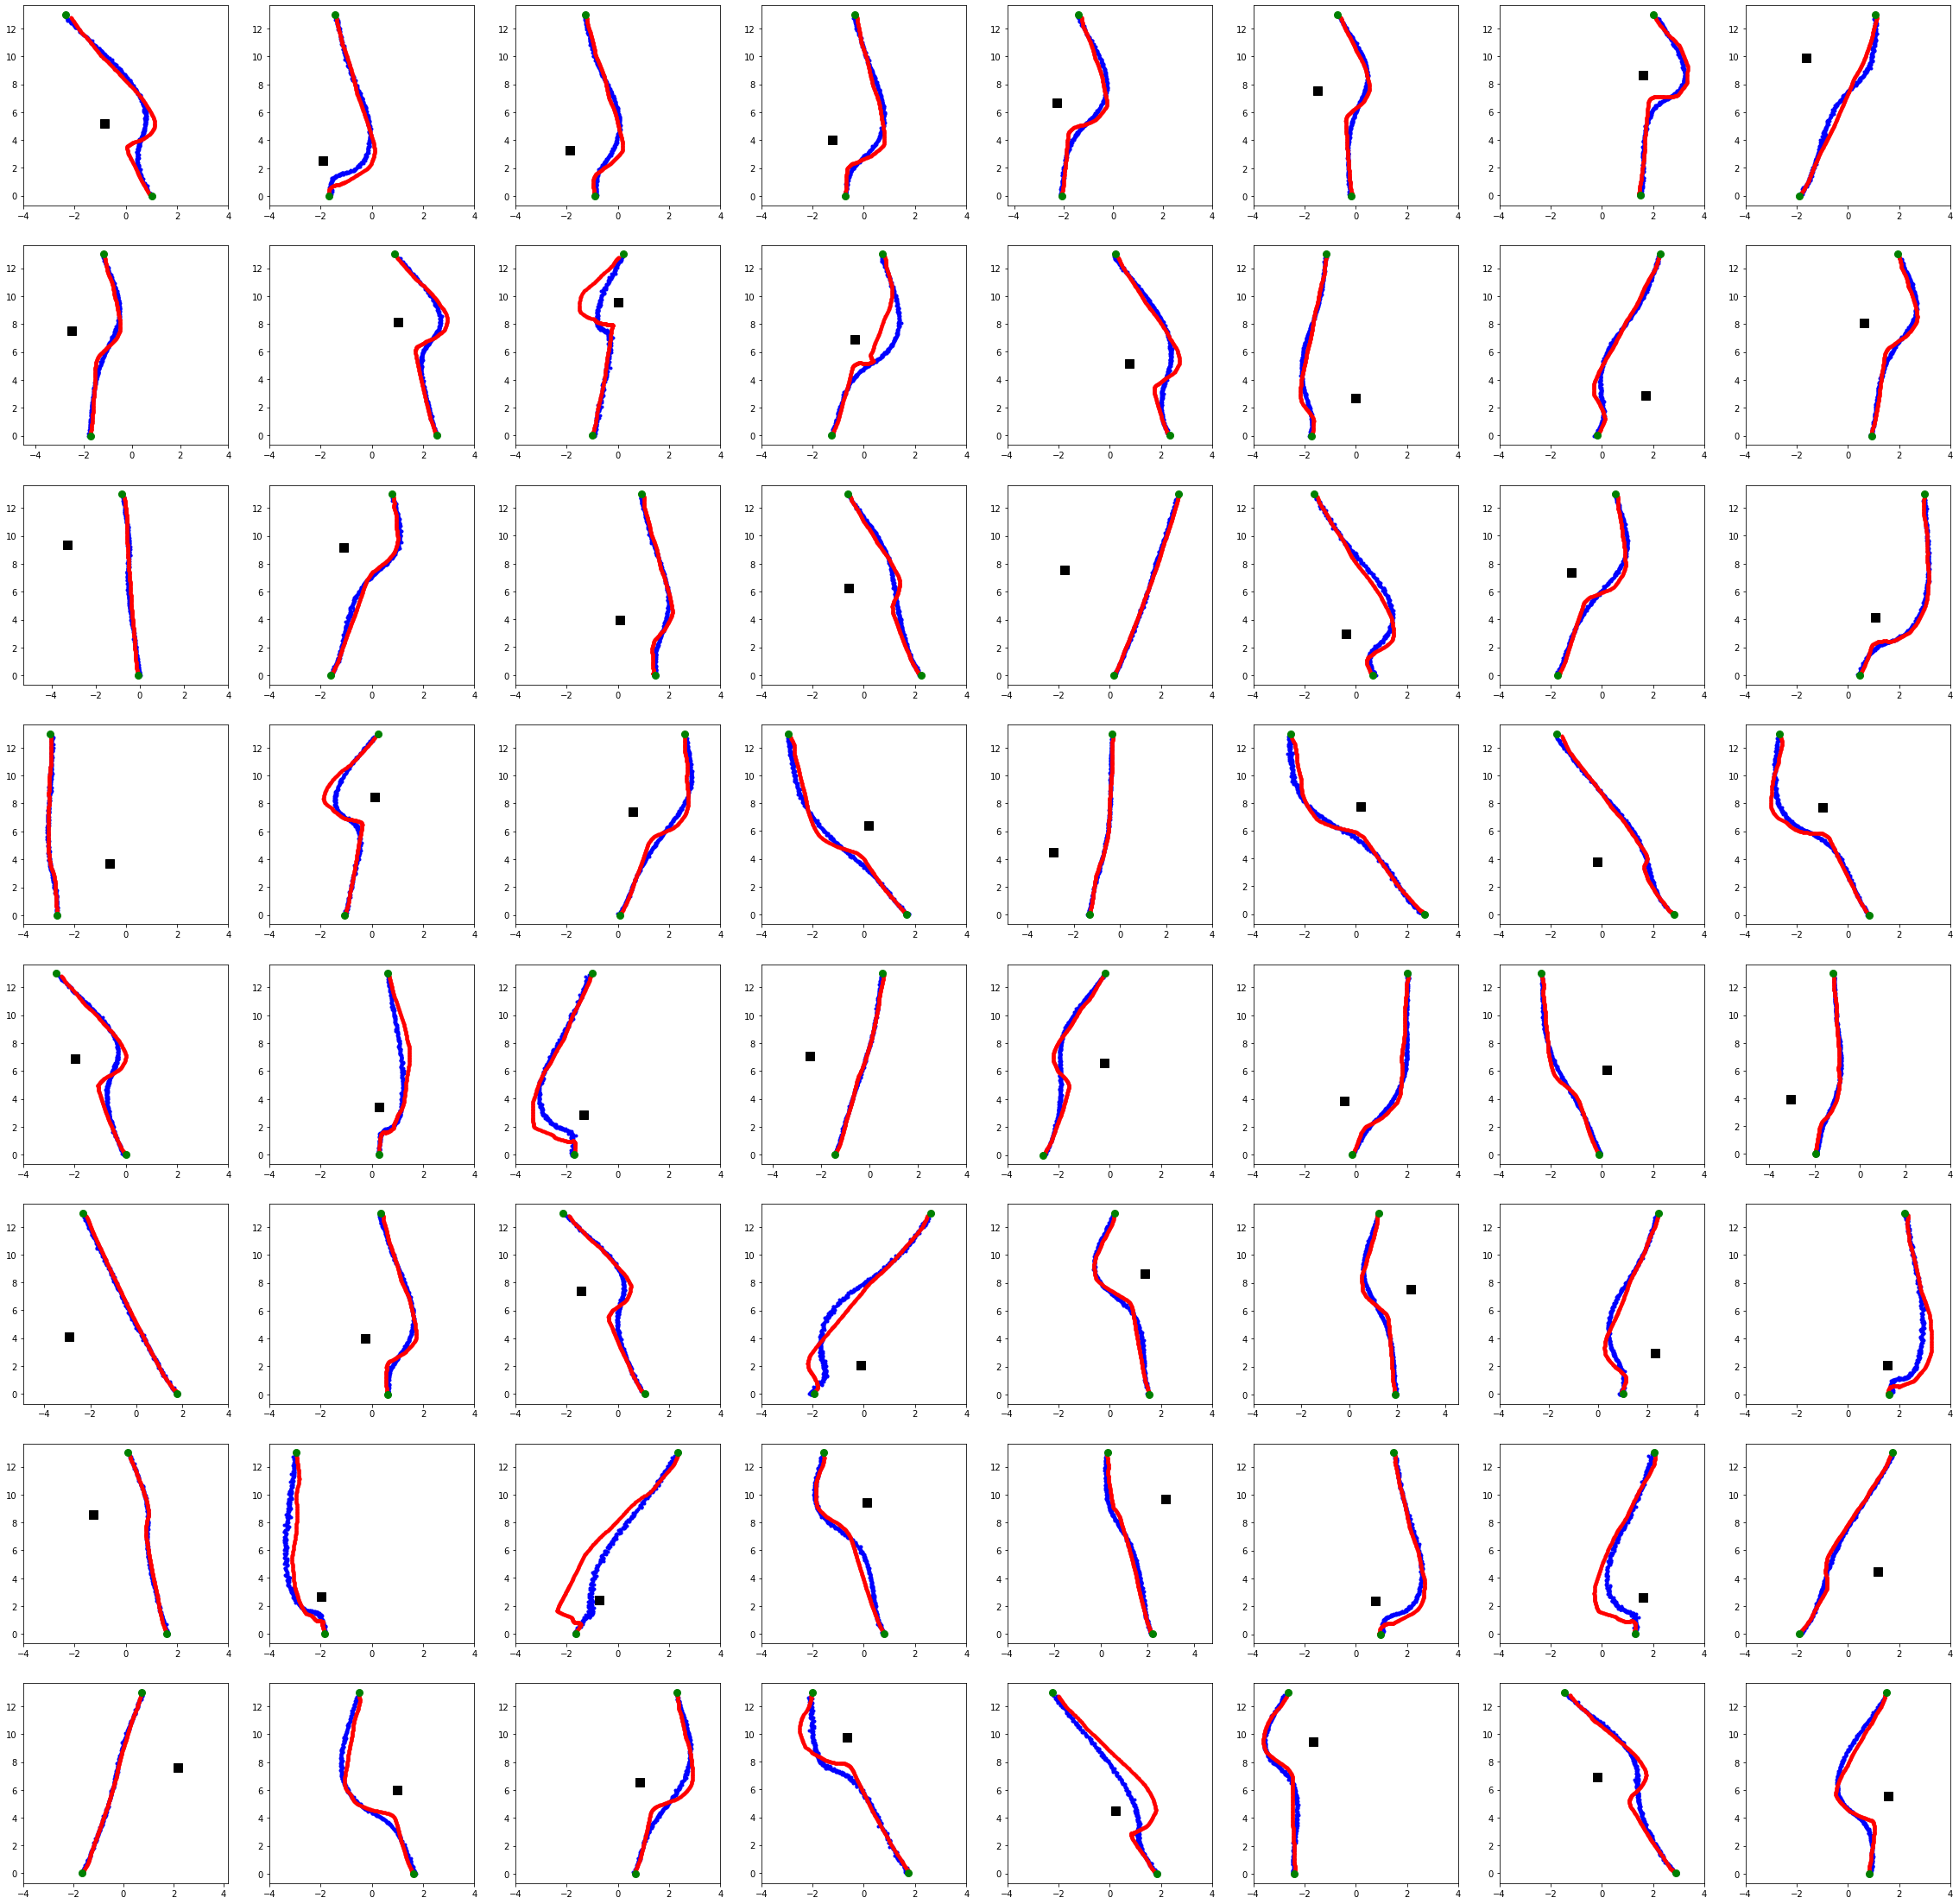

In [79]:
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [40, 40]

px, py = int(num_trajs/8), 8
fig, axs = plt.subplots(px, py)

for i in range(num_trajs):
    cur_px, cur_py = int(i/py), i%py
    
    cnmp_x, cnmp_y = cnmp_trajectories[i][:, 0], cnmp_trajectories[i][:, 1]
    x, y = trajs_coords[i, :, 0], trajs_coords[i, :, 1]
    start_x, goal_x, obs_x, obs_y = float(config[i, 0]), float(config[i, 2]), float(config[i, 4]), float(config[i, 5])
    
    axs[cur_px, cur_py].set_xlim([min(-4, obs_x-2), max(4, obs_x+2)])
    axs[cur_px, cur_py].plot(x, y, "b.")
    axs[cur_px, cur_py].plot(cnmp_x, cnmp_y, "r.")
    axs[cur_px, cur_py].plot(start_x, 0, 'go', markersize=8)
    axs[cur_px, cur_py].plot(goal_x, 13, 'go', markersize=8)
    axs[cur_px, cur_py].plot(obs_x, obs_y, 'ks', markersize=10)  # 10 is not the actual size of the obstacle

fig.savefig(f'/home/yigit/Desktop/cnmp-nn-comparison/comparison_{num_trajs}_{int(time.time())}.png')
